In [8]:
import pandas as pd
import polars as pl
import numpy as np
import os
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import pickle

from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [9]:
class CONFIG:
    seed = 42
    target_col = "responder_6"
    feature_cols = ["symbol_id", "time_id"] \
        + [f"feature_{idx:02d}" for idx in range(79)] \
        + [f"responder_{idx}_lag_1" for idx in range(9)]
    categorical_cols = []

In [10]:
train = pl.scan_parquet("./create-lags/training_data.parquet").collect().to_pandas()
valid = pl.scan_parquet("./create-lags/validation_data.parquet").collect().to_pandas()
train.shape, valid.shape

((27369232, 104), (1417152, 104))

In [11]:
#train = pd.concat([train, valid]).reset_index(drop=True)
#train.shape

In [12]:
def get_model(seed):
    # XGBoost parameters
    XGB_Params = {
        'learning_rate': 0.05,
        'max_depth': 6,
        'n_estimators': 200,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 1,
        'reg_lambda': 5,
        'random_state': seed,
        'tree_method': 'hist',
        'device' : 'cpu',
        'n_jobs': 4
    }
    
    XGB_Model = XGBRegressor(**XGB_Params)
    return XGB_Model

In [13]:
X_train = train[ CONFIG.feature_cols ]
y_train = train[ CONFIG.target_col ]
w_train = train[ "weight" ]
X_valid = valid[ CONFIG.feature_cols ]
y_valid = valid[ CONFIG.target_col ]
w_valid = valid[ "weight" ]

X_train.shape, y_train.shape, w_train.shape, X_valid.shape, y_valid.shape, w_valid.shape

((27369232, 90),
 (27369232,),
 (27369232,),
 (1417152, 90),
 (1417152,),
 (1417152,))

In [14]:
%%time
model = get_model(CONFIG.seed)
model.fit( X_train, y_train, sample_weight=w_train)

CPU times: user 17min 10s, sys: 12.1 s, total: 17min 22s
Wall time: 4min 56s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=4,
             num_parallel_tree=None, random_state=42, ...)

In [15]:
y_pred_train1 = model.predict(X_train.iloc[:X_train.shape[0]//2])
y_pred_train2 = model.predict(X_train.iloc[X_train.shape[0]//2:])
train_score = r2_score(y_train, np.concatenate([y_pred_train1, y_pred_train2], axis=0), sample_weight=w_train )
train_score

0.0293426513671875

In [16]:
y_pred_valid = model.predict(X_valid)
valid_score = r2_score(y_valid, y_pred_valid, sample_weight=w_valid )
valid_score

0.007912516593933105

In [17]:
y_means = { symbol_id : -1 for symbol_id in range(39) }
for symbol_id, gdf in train[["symbol_id", CONFIG.target_col]].groupby("symbol_id"):
    y_mean = gdf[ CONFIG.target_col ].mean()
    y_means[symbol_id] = y_mean
    print(f"symbol_id = {symbol_id}, y_means = {y_mean:.5f}")

symbol_id = 0, y_means = 0.00023
symbol_id = 1, y_means = -0.00227
symbol_id = 2, y_means = -0.00337
symbol_id = 3, y_means = 0.00402
symbol_id = 4, y_means = 0.00420
symbol_id = 5, y_means = -0.00549
symbol_id = 6, y_means = 0.00158
symbol_id = 7, y_means = -0.00068
symbol_id = 8, y_means = 0.00116
symbol_id = 9, y_means = -0.03186
symbol_id = 10, y_means = 0.00324
symbol_id = 11, y_means = 0.00149
symbol_id = 12, y_means = -0.00663
symbol_id = 13, y_means = -0.00907
symbol_id = 14, y_means = 0.00115
symbol_id = 15, y_means = 0.00613
symbol_id = 16, y_means = 0.00231
symbol_id = 17, y_means = 0.00097
symbol_id = 18, y_means = 0.00495
symbol_id = 19, y_means = 0.00990
symbol_id = 20, y_means = 0.00075
symbol_id = 21, y_means = 0.00023
symbol_id = 22, y_means = -0.00124
symbol_id = 23, y_means = 0.00534
symbol_id = 24, y_means = -0.01018
symbol_id = 25, y_means = -0.01627
symbol_id = 26, y_means = -0.00244
symbol_id = 27, y_means = -0.00573
symbol_id = 28, y_means = -0.00587
symbol_id =

In [18]:
cv_detail = { symbol_id : 0 for symbol_id in range(39) }
for symbol_id, gdf in valid.groupby("symbol_id"):
    X_valid = gdf[ CONFIG.feature_cols ]
    y_valid = gdf[ CONFIG.target_col ]
    w_valid = gdf[ "weight" ]
    y_pred_valid = model.predict(X_valid)
    score = r2_score(y_valid, y_pred_valid, sample_weight=w_valid )
    cv_detail[symbol_id] = score
    
    print(f"symbol_id = {symbol_id}, score = {score:.5f}")

symbol_id = 0, score = 0.00223
symbol_id = 1, score = 0.00332
symbol_id = 2, score = 0.00408
symbol_id = 3, score = 0.00471
symbol_id = 4, score = 0.01239
symbol_id = 5, score = -0.00189
symbol_id = 6, score = 0.00189
symbol_id = 7, score = 0.00163
symbol_id = 8, score = 0.01262
symbol_id = 9, score = 0.00817
symbol_id = 10, score = 0.00182
symbol_id = 11, score = 0.00850
symbol_id = 12, score = 0.00569
symbol_id = 13, score = 0.03798
symbol_id = 14, score = 0.00367
symbol_id = 15, score = 0.00009
symbol_id = 16, score = 0.00987
symbol_id = 17, score = 0.01546
symbol_id = 18, score = -0.00230
symbol_id = 19, score = 0.01370
symbol_id = 20, score = 0.04896
symbol_id = 21, score = 0.01743
symbol_id = 22, score = 0.02298
symbol_id = 23, score = -0.00009
symbol_id = 24, score = 0.02223
symbol_id = 25, score = 0.01034
symbol_id = 26, score = -0.00059
symbol_id = 27, score = -0.00167
symbol_id = 28, score = 0.00401
symbol_id = 29, score = 0.00654
symbol_id = 30, score = 0.00054
symbol_id = 3

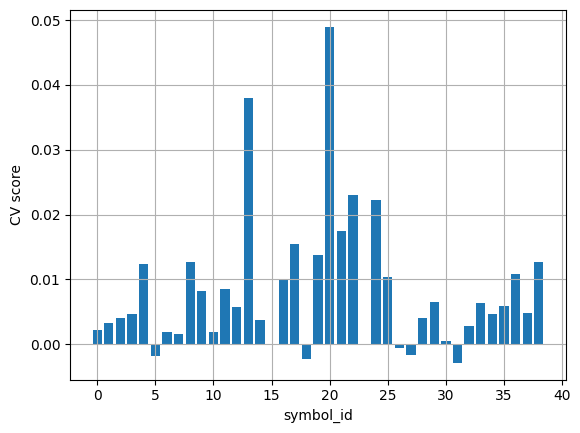

In [19]:
sids = list(cv_detail.keys())
plt.bar(sids, [cv_detail[sid] for sid in sids])
plt.grid()
plt.xlabel("symbol_id")
plt.ylabel("CV score")
plt.show()

In [20]:
result = {
    "model" : model,
    "cv" : valid_score,
    "cv_detail" : cv_detail,
    "y_mean" : y_means,
}
with open("result.pkl", "wb") as fp:
    pickle.dump(result, fp)